У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

## 1

In [1]:
import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train_store.csv',sep=';')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

In [5]:
print("Shape:", df.shape)
print(df.head(10))
print("\nDataFrame info:")
print(df.info())

Shape: (913000, 3)
            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-01      7    12     26
2013-01-01      7    46     27
2013-01-01      8    12     54
2013-01-01      9    12     35
2013-01-01     10    12     41
2013-01-01      6    46     23
2013-01-01      1    13     37
2013-01-01      2    13     51
2013-01-01      5    46     20

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


## 2

Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.


Напишіть висновок з побудованих вами візуалізацій.

  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.

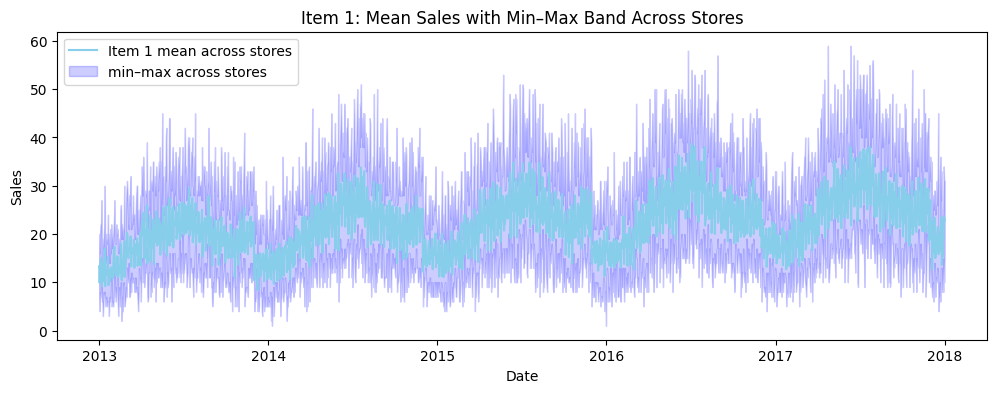

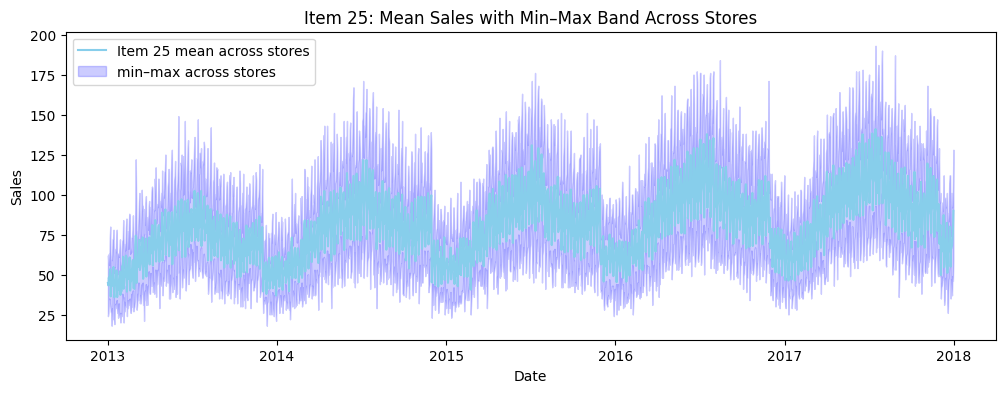

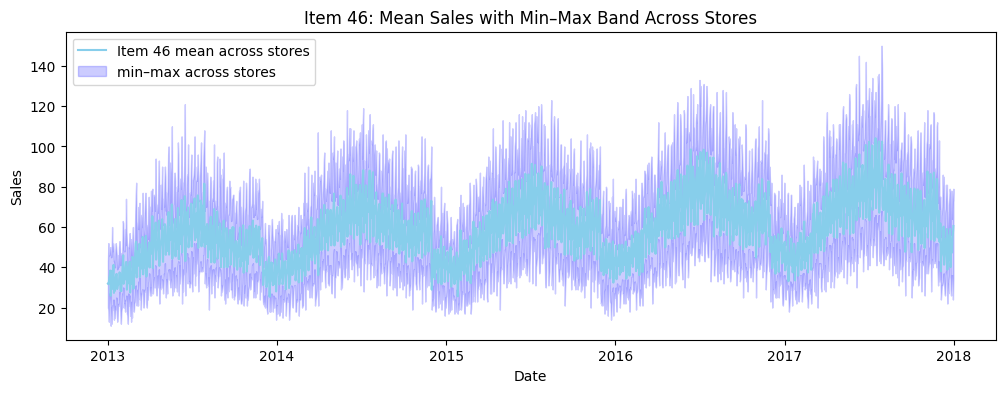

In [6]:
sample_items = [1, 25, 46]

figs = []
for it in sample_items:
    tmp = df[df['item'] == it]
    pivot = tmp.pivot_table(index=tmp.index, columns='store', values='sales')
    pivot = pivot.asfreq('D').interpolate() # filled missed days if there

    mean_series = pivot.mean(axis=1)
    min_series = pivot.min(axis=1)
    max_series = pivot.max(axis=1)

    plt.figure(figsize=(12,4))
    plt.plot(mean_series.index, mean_series.values, label=f'Item {it} mean across stores',color='skyblue')
    plt.fill_between(mean_series.index, min_series.values, max_series.values, alpha=0.2, label='min–max across stores',color='blue')
    plt.title(f'Item {it}: Mean Sales with Min–Max Band Across Stores')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

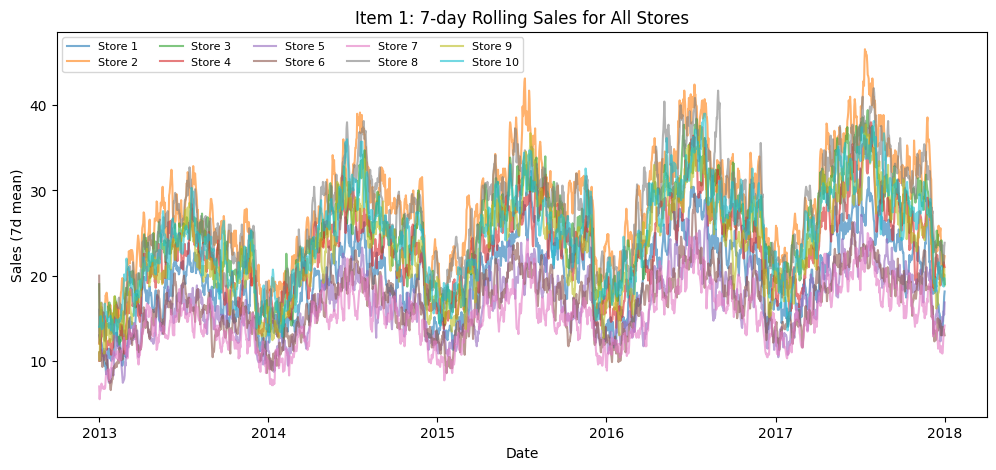

In [7]:
item_for_overlay = 1
tmp = df[df['item'] == item_for_overlay]
pivot = tmp.pivot_table(index=tmp.index, columns='store', values='sales').asfreq('D').interpolate()
smoothed = pivot.rolling(7, min_periods=1).mean()

plt.figure(figsize=(12,5))
for col in smoothed.columns:
    plt.plot(smoothed.index, smoothed[col], alpha=0.6, label=f'Store {col}')
plt.title(f'Item {item_for_overlay}: 7-day Rolling Sales for All Stores')
plt.xlabel('Date')
plt.ylabel('Sales (7d mean)')
plt.legend(ncol=5, fontsize=8)
plt.show()

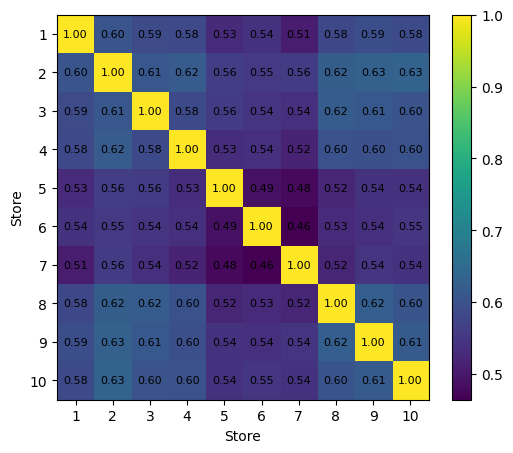

In [8]:
corr = pivot.corr()

plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect='auto', interpolation='nearest')
plt.xlabel('Store')
plt.ylabel('Store')
plt.xticks(ticks=np.arange(10), labels=[str(s) for s in corr.columns])
plt.yticks(ticks=np.arange(10), labels=[str(s) for s in corr.index])
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=8)
plt.colorbar()
plt.show()

*   перший графік показує, що для айтемів є чітка річна сезонність, і при цьому видно що є велика різниця між мінімальним значенням і максимальним значенням в продажах - тобто магазини продають різну кількість того ж товару
*   оскільки дуже багато даних, на другому графіку вирішила взяти ковзне середнє за період 7 днів, і висновок чатсково такий самий, що сезонність є, кількісит продажів коливається
* кореляція показує, що варіант 1 модель на всі магазини не підійде :)



## 3

**Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
s11 = df[(df['store']==1) & (df['item']==1)]

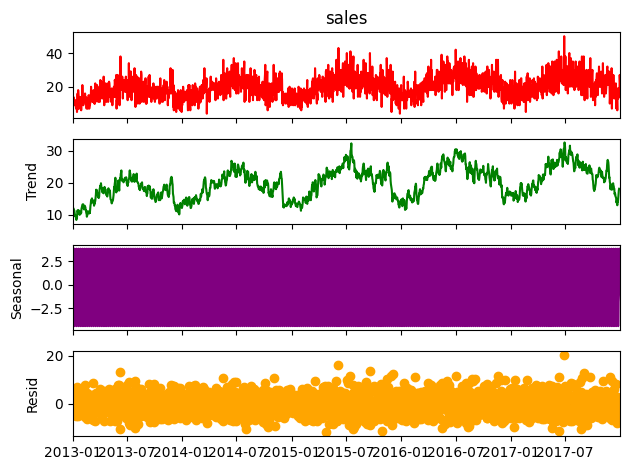

In [11]:
decomposition_plot = seasonal_decompose(s11.sales, model='additive', period=7)
fig = decomposition_plot.plot()
axes = fig.get_axes()
colors = ['red', 'green', 'purple', 'orange']
for i, ax in enumerate(axes):
  if ax.lines:
    ax.lines[0].set_color(colors[i])
plt.show()

Тут є дві сезонності - тижнева і річна

Також дуже багато резідалів

## 4

Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [6]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
from darts import TimeSeries

In [8]:
series = TimeSeries.from_dataframe(s11, value_cols='sales')

In [15]:
series.values()

array([[13.],
       [11.],
       [14.],
       ...,
       [15.],
       [27.],
       [23.]])

## 5

Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [9]:
train, val = series.split_before(pd.Timestamp('2017-10-01'))

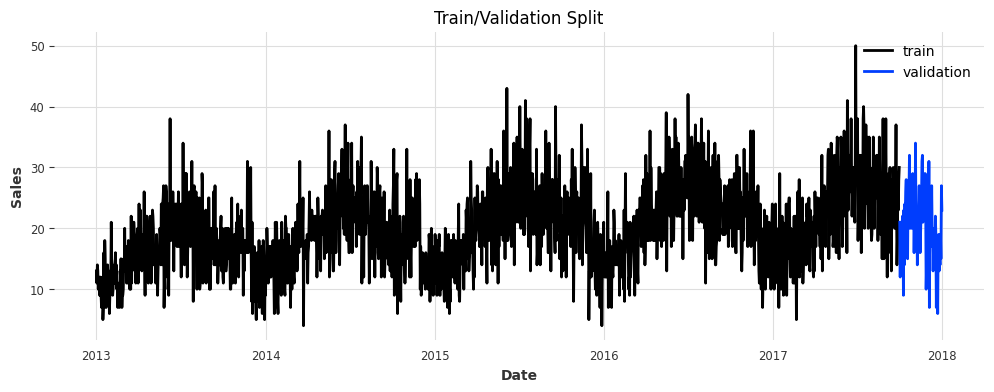

In [17]:
plt.figure(figsize=(12,4))
train.plot(label='train')
val.plot(label='validation')
plt.title('Train/Validation Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 6

Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1000x400 with 0 Axes>

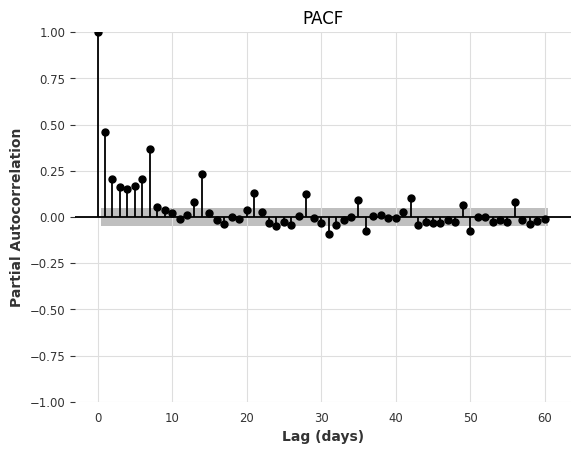

In [19]:
plt.figure(figsize=(10,4))
plot_pacf(train.to_series(), lags=60, method='ywm')
plt.title('PACF')
plt.xlabel('Lag (days)')
plt.ylabel('Partial Autocorrelation')
plt.show()


* високі лаги перших днів - залежність продажів віж попередніх днів
* чітко видно що лаг 7 виділяється, що підтверджує тижневу залежність


## 7

Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [20]:
from darts.utils.statistics import check_seasonality

for m in [7, 14, 30, 365]:
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05, max_lag=400)
    if is_seasonal:
      print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.


## 8

Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [10]:
from darts.models import NaiveSeasonal, NaiveDrift
from darts.metrics import mape

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b8b8c4116c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


In [11]:
n = len(val)

In [12]:
model_ns = NaiveSeasonal(K=7)

In [24]:
model_ns.fit(train)

NaiveSeasonal(K=7)

In [25]:
forecast_ns = model_ns.predict(n)

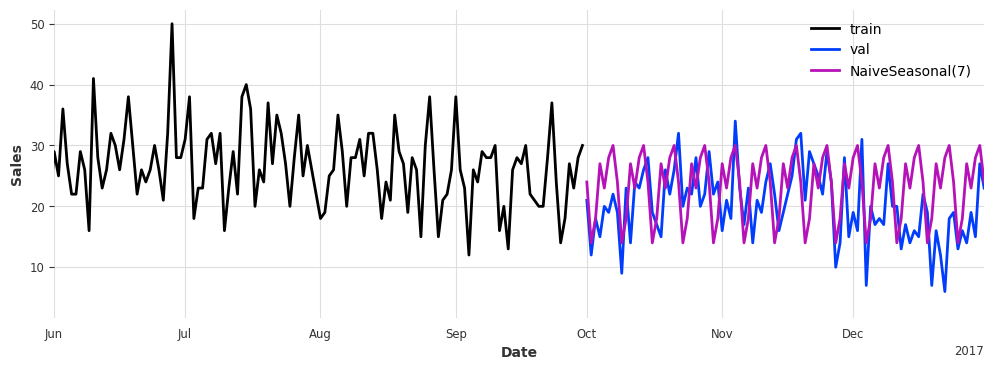

In [26]:
plt.figure(figsize=(12,4))
train.plot(label='train')
val.plot(label='val')
forecast_ns.plot(label='NaiveSeasonal(7)')
plt.xlim(pd.Timestamp("2017-06-01"), pd.Timestamp("2017-12-31"))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [27]:
model_nd = NaiveDrift()

In [28]:
model_nd.fit(train)

NaiveDrift()

In [29]:
forecast_nd = model_nd.predict(n)

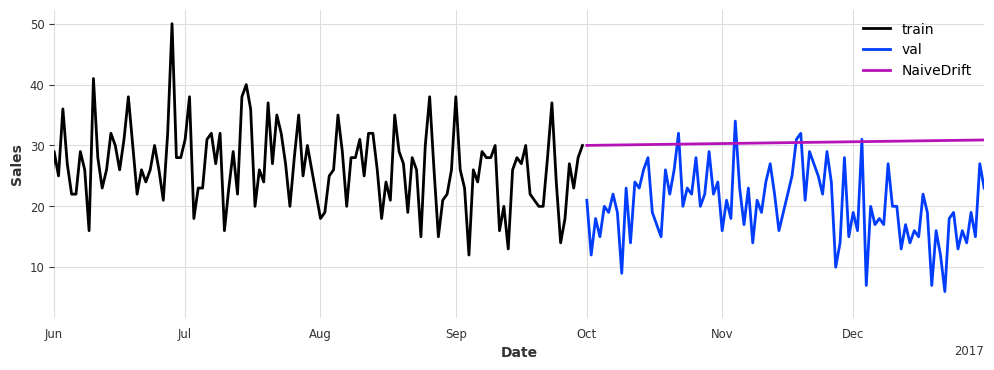

In [30]:
plt.figure(figsize=(12,4))
train.plot(label='train')
val.plot(label='val')
forecast_nd.plot(label='NaiveDrift')
plt.xlim(pd.Timestamp("2017-06-01"), pd.Timestamp("2017-12-31"))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

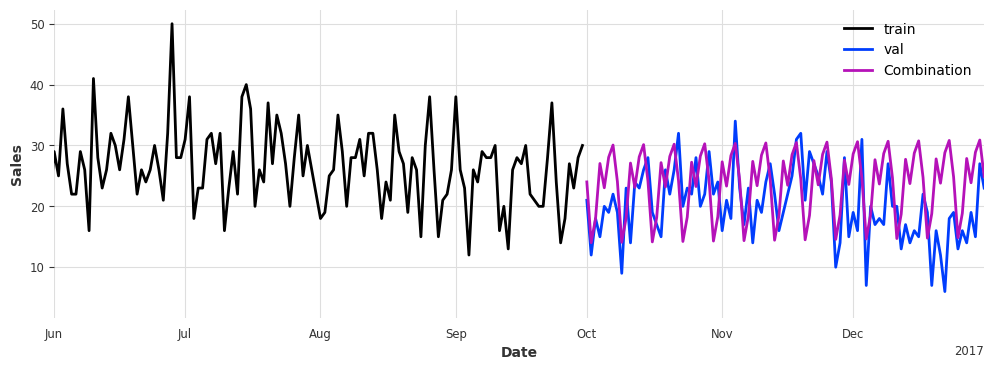

In [31]:
combined_forecast = forecast_nd + forecast_ns - train.last_value()
plt.figure(figsize=(12,4))
train.plot(label='train')
val.plot(label='val')
combined_forecast.plot(label='Combination')
plt.xlim(pd.Timestamp("2017-06-01"), pd.Timestamp("2017-12-31"))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

з графіків виглядає, що в моделях прям занадто чітка сезонність - яка не є в наших данних

## 9

Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [32]:
print("Naive Seasonal MAPE:", mape(val, forecast_ns))
print("Naive Drift MAPE:", mape(val, forecast_nd))
print("Combined MAPE:", mape(val, combined_forecast))

Naive Seasonal MAPE: 38.174845664426456
Naive Drift MAPE: 68.74405050496789
Combined MAPE: 39.90628951234137


## 10

Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [33]:
from darts.models import XGBModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.dataprocessing.transformers import Scaler

In [34]:
def enrich_with_date_features(df):
    df["dayofweek"] = df['date'].dt.dayofweek
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    df["dayofyear"] = df['date'].dt.dayofyear
    df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

    df["month"] = df['date'].dt.month
    df["year"] = df['date'].dt.year

    return df

In [35]:
train_transformed = enrich_with_date_features(train.to_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.to_dataframe().reset_index())

In [36]:
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)

In [37]:
xgb = XGBModel(
    lags=365,
    output_chunk_length=30,
    random_state=42
)

In [38]:
xgb.fit(train_transformed)

XGBModel(lags=365, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=30, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

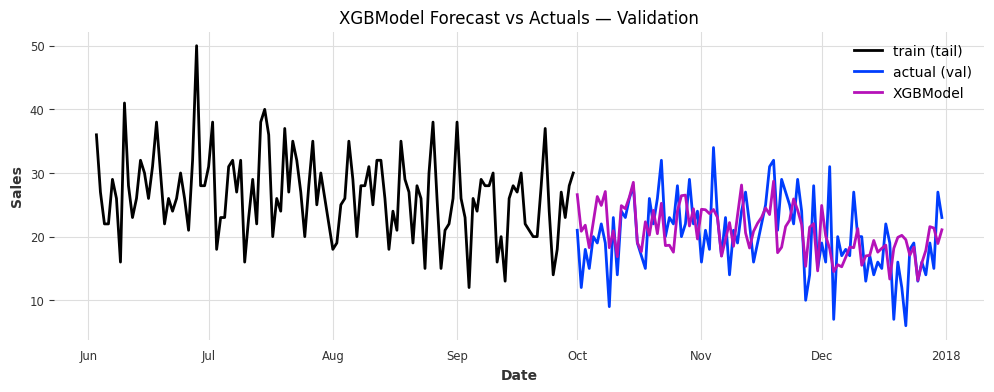

XGBModel MAPE: 26.031%


In [39]:
forecast_xgb_scaled = xgb.predict(len(val_transformed))
forecast_xgb = scaler.inverse_transform(forecast_xgb_scaled)

# Plot
plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
forecast_xgb.plot(label='XGBModel')
plt.title('XGBModel Forecast vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

mape_xgb = mape(val, forecast_xgb)
print(f"XGBModel MAPE: {mape_xgb:.3f}%")

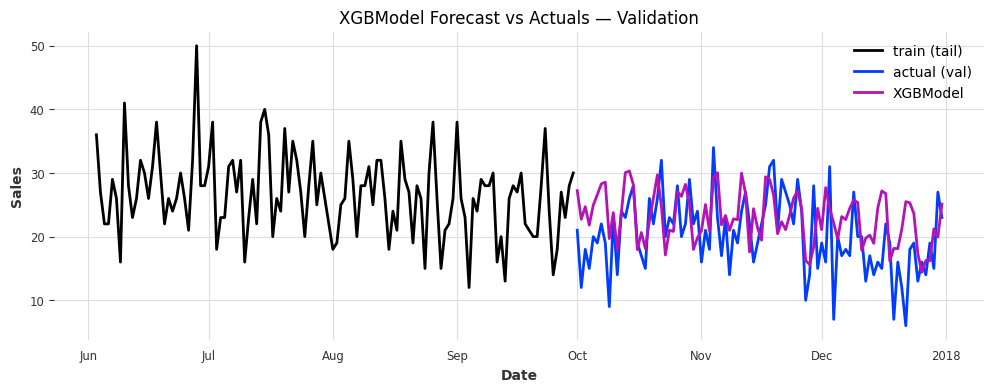

XGBModel MAPE: 32.326%


In [40]:
xgb7 = XGBModel(
    lags=7,
    output_chunk_length=30,
    random_state=42
)
xgb7.fit(train_transformed)
forecast_xgb_scaled7 = xgb7.predict(len(val_transformed))
forecast_xgb7 = scaler.inverse_transform(forecast_xgb_scaled7)

# Plot
plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
forecast_xgb7.plot(label='XGBModel')
plt.title('XGBModel Forecast vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

mape_xgb = mape(val, forecast_xgb7)
print(f"XGBModel MAPE: {mape_xgb:.3f}%")

Оскільки дані двосеззоні спробувала натренувати цю модель і на тижневій і на річній

Краще себе показала річна, але і тижнева не погана

## 11

Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [41]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode,SeasonalityMode

In [42]:
model_es = ExponentialSmoothing(seasonal_periods=7,
                                trend=ModelMode.ADDITIVE,
                                seasonal= SeasonalityMode.ADDITIVE)
model_es.fit(train)
forecast_es = model_es.predict(n)

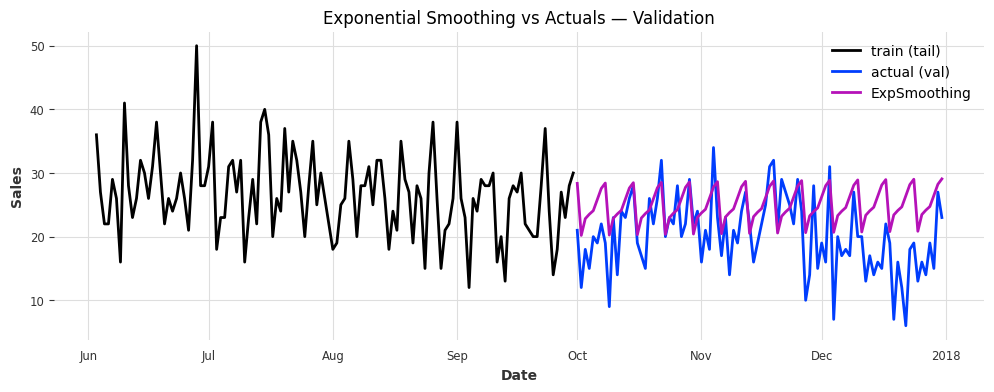

ExpSmoothing MAPE: 39.009%


In [43]:
plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
(forecast_es).plot(label='ExpSmoothing')
plt.title('Exponential Smoothing vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

print(f"ExpSmoothing MAPE: {mape(val, forecast_es):.3f}%")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


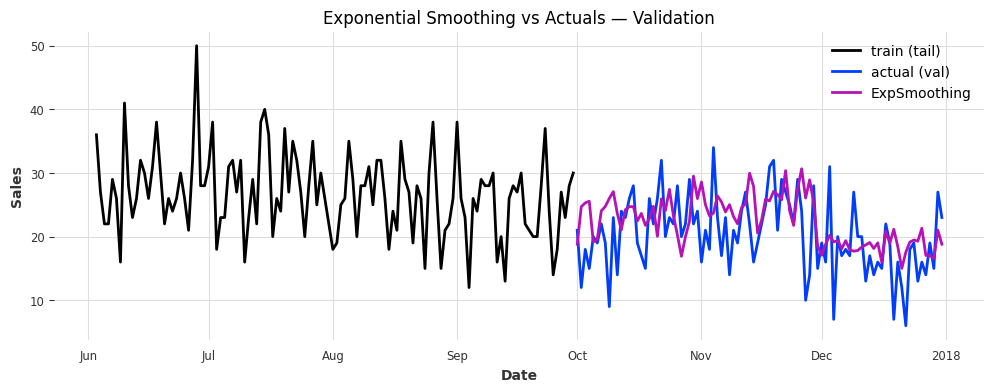

ExpSmoothing MAPE: 30.863%


In [44]:
model_es365 = ExponentialSmoothing(seasonal_periods=365,
                                trend=ModelMode.ADDITIVE,
                                seasonal= SeasonalityMode.ADDITIVE)
model_es365.fit(train)
forecast_es365 = model_es365.predict(n)

plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
(forecast_es365).plot(label='ExpSmoothing')
plt.title('Exponential Smoothing vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

print(f"ExpSmoothing MAPE: {mape(val, forecast_es365):.3f}%")

За тією ж логікою що вище

Краще себе показала річна модель, видно що це не однакова підігнана лінія

## 12

Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [45]:
from darts.models import ARIMA, AutoARIMA

In [46]:
m_arima7 = ARIMA(p=3,d=0,q=3, seasonal_order=(1,1,1,7))
m_arima7.fit(train)
fc_arima7 = m_arima7.predict(len(val))

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


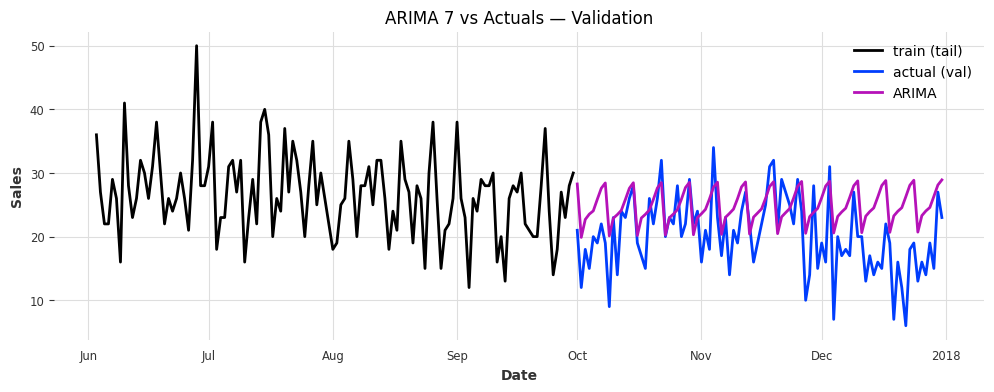

ARIMA MAPE: 38.562%


In [47]:
plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
fc_arima7.plot(label='ARIMA')
plt.title('ARIMA 7 vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
print(f"ARIMA MAPE: {mape(val, fc_arima7):.3f}%")


досить схожа модель на ExponentialSmoothing тижневу

## 13

Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [48]:
m_auto7 = AutoARIMA(
    start_p=0, start_q=0, max_p=5, max_q=5,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    seasonal=True, season_length=7, stepwise=True, random_state=42
)
m_auto7.fit(train)
fc_auto7 = m_auto7.predict(len(val))

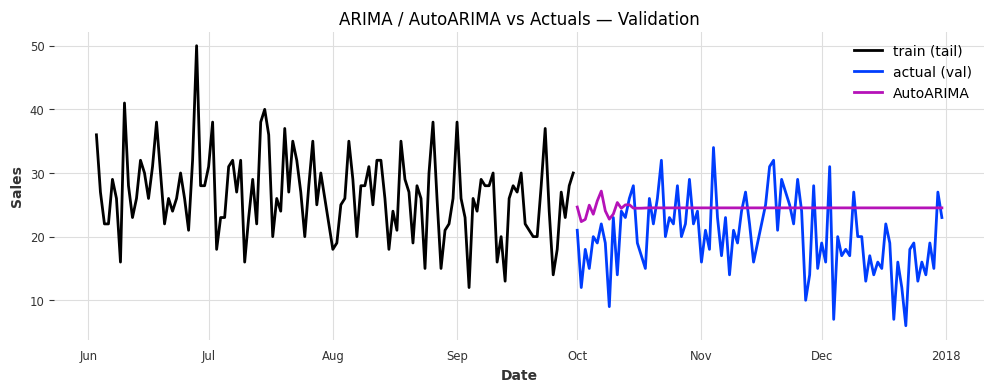

AutoARIMA MAPE: 40.558%


In [49]:
plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
fc_auto7.plot(label='AutoARIMA')
plt.title('ARIMA / AutoARIMA vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
print(f"AutoARIMA MAPE: {mape(val, fc_auto7):.3f}%")

не знаю що тут коментувати)

складно цій моделі, бо навіть якщо брати що пряму лінію воно намалювало в терії як середню з даних, всеодно не добре

не той метод для подвійної сезонності

## 14

Натренуйте модель Prophet та зробіть висновок про її якість.

In [17]:
from darts.models import Prophet

In [18]:
m_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
)

In [19]:
m_prophet.fit(train)
fc_prophet = m_prophet.predict(n)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp821qvey/m_9s6ts0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp821qvey/hymif01e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4250', 'data', 'file=/tmp/tmpp821qvey/m_9s6ts0.json', 'init=/tmp/tmpp821qvey/hymif01e.json', 'output', 'file=/tmp/tmpp821qvey/prophet_modelzb6bkqz7/prophet_model-20250910200307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp821qvey/u0nhd9fd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp821qvey/lu1t442o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49256', 'data', 'file=/tmp/tmpp821qvey/u0nhd9fd.json', 'init=/tmp/tmpp821qvey/lu1t442o.json', 'output', 'file=/tmp/tmpp821qvey/prophet_model8yro39nj/prophet_model-20250910200312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


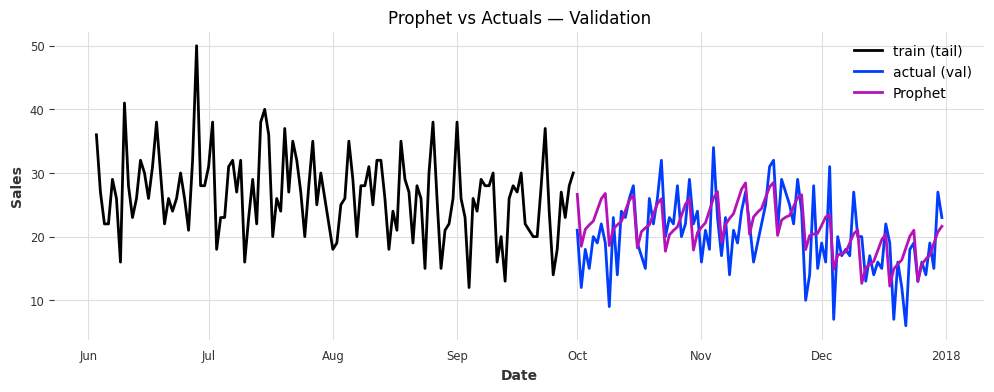

Prophet MAPE: 23.805%


In [20]:
m_prophet.fit(train)
fc_prophet = m_prophet.predict(len(val))

plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
fc_prophet.plot(label='Prophet')
plt.title('Prophet vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

print(f"Prophet MAPE: {mape(val, fc_prophet):.3f}%")

тут модель враховує подвійну сезонність - і тому не дивно що показала себе найкраще

## 15

Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [13]:
from darts.models import RNNModel

In [14]:
model_rnn = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)

In [15]:
model_rnn.fit(train)
fc_rnn = model_rnn.predict(n)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

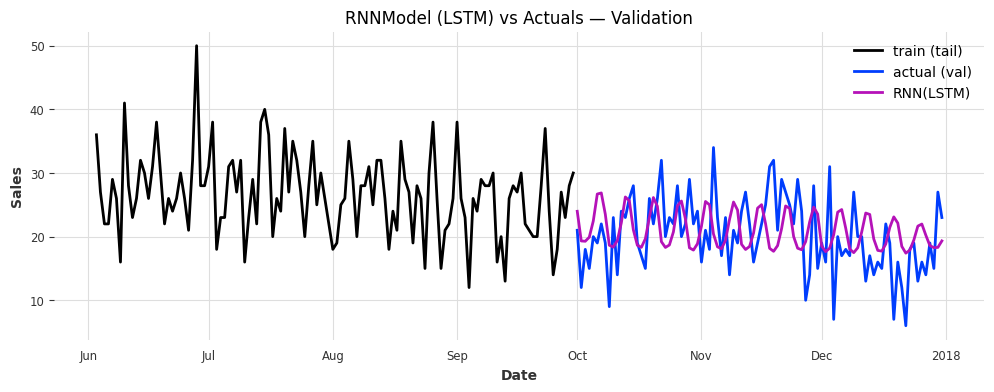

RNN(LSTM) MAPE: 31.490%


In [16]:
plt.figure(figsize=(12,4))
train.tail(120).plot(label='train (tail)')
val.plot(label='actual (val)')
fc_rnn.plot(label='RNN(LSTM)')
plt.title('RNNModel (LSTM) vs Actuals — Validation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

print(f"RNN(LSTM) MAPE: {mape(val, fc_rnn):.3f}%")

модель показала себе досить непогано, вона добре передбачає на середніх значенях, але результат все ж гірший ніж Prophet
- можна спробувати налаштувати гіперпараметри можливо буде кращий результат

## 16
Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [22]:
from datetime import timedelta

In [23]:
fh = 30      # forecast horizon = 1 month
stride = 30  # 1 month each step
start_time = series.end_time() - timedelta(days=365)

In [25]:
prophet_forecasts = m_prophet.historical_forecasts(
    series=series,
    start=start_time,
    forecast_horizon=fh,
    stride=stride,
    retrain=True,
    verbose=True
)

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp821qvey/gbpq4rfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp821qvey/zrhvo0gf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81536', 'data', 'file=/tmp/tmpp821qvey/gbpq4rfw.json', 'init=/tmp/tmpp821qvey/zrhvo0gf.json', 'output', 'file=/tmp/tmpp821qvey/prophet_modelfc7usn7e/prophet_model-20250910201342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:13:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:13:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   8%|▊         | 1/12 [00:00<00:03,  3.30it/s]INFO:prophet:D

In [26]:
bt_mape = mape(series.slice_intersect(prophet_forecasts), prophet_forecasts)
print(f"Prophet Backtest MAPE over last year: {bt_mape:.3f}%")

Prophet Backtest MAPE over last year: 14.726%


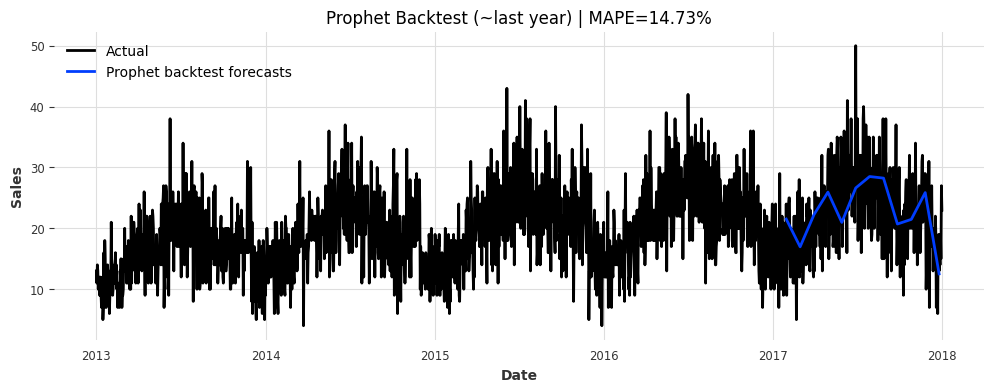

In [27]:
plt.figure(figsize=(12,4))
series.plot(label='Actual')
prophet_forecasts.plot(label='Prophet backtest forecasts')
plt.title(f'Prophet Backtest (~last year) | MAPE={bt_mape:.2f}%')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

- лінія Prophet загалом слідує за лінією фактичних даних, відображаючи загальну тенденцію
- MAPE = 14,73% - це дуже добрий результат, як на мене
- прогнози Prophet виглядають більш згладженими, ніж фактичні дані
- пропускає деякі різкі стрибки, що сприяє виникненню похибок.


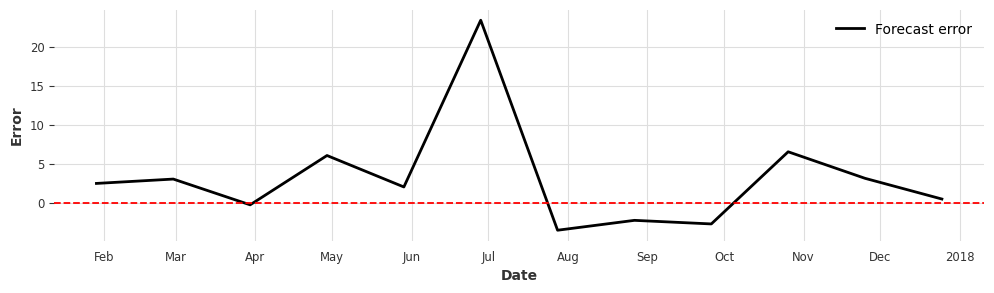

In [30]:
errors = series.slice_intersect(prophet_forecasts) - prophet_forecasts

plt.figure(figsize=(12, 3))
errors.plot(label="Forecast error")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()
plt.show()


- у липні є явний великий стрибок,який Prophet не зміг врахувати
- до і після цього стрибка похибки виглядають відносно невеликими, тобто Prophet загалом є стабільним

Всю варіантивність не вгадали, але виглядає непогано!

## 17

На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

*швидше за все спочатку спробвала тренувати якусь загальну модель, бо тренувати на кожен товар і магазин то прям дуже багато*

*використовувати б Prophet, RNN(з кращими параметрами) і ще якісь моделі, які можуть справлятись з подвійною сезонністю*

*також можна було б спробувати якось погрупувати товари або магазин, щоб зменшити трохи шум даних*
